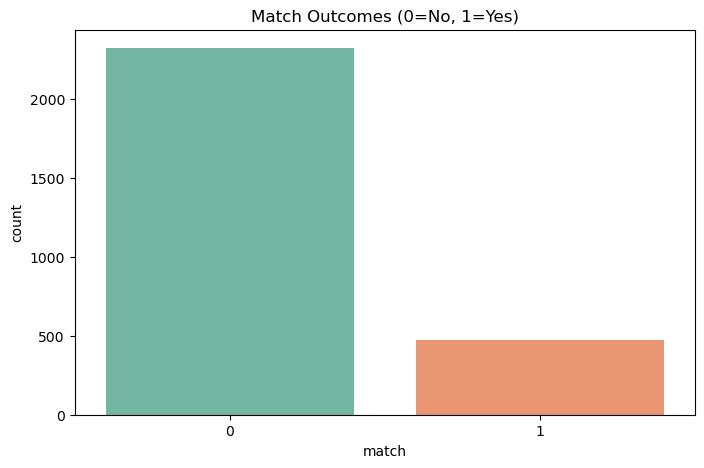

Class balance:
0    0.830357
1    0.169643
Name: match, dtype: float64


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('dating_data_modeling.csv')

# Check target distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='match', palette='Set2')
plt.title("Match Outcomes (0=No, 1=Yes)")
plt.show()

print(f"Class balance:\n{df['match'].value_counts(normalize=True)}")

In [5]:
df.columns

Index(['gender', 'age', 'age_o', 'samerace', 'int_corr', 'total_attr_compat',
       'personality_alignment', 'attr_perception_gap', 'ambition_gap',
       'gender_attr_interaction', 'age_compatibility', 'cluster_attr_match',
       'attr_gap', 'like_o', 'prob_o', 'dec_o', 'match'],
      dtype='object')

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('dating_data_modeling.csv')

# Select features - using all available except decision-related columns
features = [
    'gender', 'age', 'age_o', 'samerace', 'int_corr', 
    'total_attr_compat', 'personality_alignment', 'attr_perception_gap',
    'ambition_gap', 'gender_attr_interaction', 'age_compatibility',
    'cluster_attr_match', 'attr_gap', 'like_o', 'prob_o'
]

X = df[features]
y = df['match']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
## 2. Baseline Model (Random Forest)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced_subsample',
    random_state=42
)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

print("Baseline Random Forest:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Baseline Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       465
           1       0.81      0.40      0.54        95

    accuracy                           0.88       560
   macro avg       0.85      0.69      0.73       560
weighted avg       0.88      0.88      0.87       560

AUC-ROC: 0.8927


In [8]:
# 3. Advanced Sampling with SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

smote_pipeline = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )
)

smote_pipeline.fit(X_train_scaled, y_train)
y_pred_smote = smote_pipeline.predict(X_test_scaled)

print("\nRandom Forest with SMOTE:")
print(classification_report(y_test, y_pred_smote))


Random Forest with SMOTE:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       465
           1       0.62      0.58      0.60        95

    accuracy                           0.87       560
   macro avg       0.77      0.75      0.76       560
weighted avg       0.87      0.87      0.87       560



In [9]:
# 4. XGBoost with Feature Importance

from xgboost import XGBClassifier

# Calculate class weight
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train_scaled, y_train)

# Feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance)

y_pred_xgb = xgb.predict(X_test_scaled)
print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:26:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Feature Importance:
                    feature  importance
6     personality_alignment    0.152301
13                   like_o    0.121995
5         total_attr_compat    0.121162
3                  samerace    0.082641
7       attr_perception_gap    0.069355
10        age_compatibility    0.068836
8              ambition_gap    0.067351
14                   prob_o    0.056983
9   gender_attr_interaction    0.048241
2                     age_o    0.047941
4                  int_corr    0.046453
1                       age    0.044786
12                 attr_gap    0.044304
0                    gender    0.027649
11       cluster_attr_match    0.000000

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       465
           1       0.67      0.68      0.68        95

    accuracy                           0.89       560
   macro avg       0.80      0.81      0.81       560
weighted avg       0.89      0.89      0.89  

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Calculate scale_pos_weight first
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Define parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight*1.5, scale_pos_weight*2]
}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model
search.fit(X_train_scaled, y_train)

# Get best estimator
best_xgb = search.best_estimator_

# Make predictions
y_pred_best = best_xgb.predict(X_test_scaled)
y_proba_best = best_xgb.predict_proba(X_test_scaled)[:,1]

# Evaluate
print("\nBest XGBoost:")
print(classification_report(y_test, y_pred_best))
print(f"Best AUC-ROC: {roc_auc_score(y_test, y_proba_best):.4f}")
print("Best Parameters:", search.best_params_)

# Feature importance
importance = best_xgb.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:26:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:26:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:26:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:26:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/


Best XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       465
           1       0.65      0.71      0.68        95

    accuracy                           0.89       560
   macro avg       0.79      0.81      0.80       560
weighted avg       0.89      0.89      0.89       560

Best AUC-ROC: 0.9200
Best Parameters: {'colsample_bytree': 0.9193380499938204, 'gamma': 0.07535877198271473, 'learning_rate': 0.1624596330222156, 'max_depth': 7, 'reg_alpha': 0.8583588048137198, 'reg_lambda': 0.32595890520188475, 'scale_pos_weight': 9.789473684210526, 'subsample': 0.884459812975207}

Feature Importance:
                    feature  importance
6     personality_alignment    0.166809
5         total_attr_compat    0.104405
13                   like_o    0.104144
3                  samerace    0.071764
8              ambition_gap    0.063474
10        age_compatibility    0.061518
7       attr_perception_gap    0.060980
0               

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# 1. Load and prepare data
df = pd.read_csv('dating_data_modeling.csv')

# Select features and target
features = [
    'gender', 'age', 'age_o', 'samerace', 'int_corr', 
    'total_attr_compat', 'personality_alignment', 'attr_perception_gap',
    'ambition_gap', 'gender_attr_interaction', 'age_compatibility',
    'cluster_attr_match', 'attr_gap', 'like_o', 'prob_o'
]
X = df[features]
y = df['match']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Calculate class weight
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale_pos_weight calculated as: {scale_pos_weight:.2f}")

# 5. Hyperparameter tuning setup
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight*1.5, scale_pos_weight*2]
}

# 6. Initialize and run RandomizedSearchCV
search = RandomizedSearchCV(
    XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting hyperparameter tuning...")
search.fit(X_train_scaled, y_train)
print("Tuning completed!")

# 7. Evaluate best model
best_xgb = search.best_estimator_
y_pred_best = best_xgb.predict(X_test_scaled)
y_proba_best = best_xgb.predict_proba(X_test_scaled)[:,1]

print("\nBest XGBoost Performance:")
print(classification_report(y_test, y_pred_best))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_best):.4f}")
print("\nBest Parameters:", search.best_params_)

# 8. Feature importance
importance = best_xgb.feature_importances_
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Scale_pos_weight calculated as: 4.89
Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:28:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:28:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:28:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:28:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jerono/anaconda3/lib/python3.11/site-packages/

Tuning completed!

Best XGBoost Performance:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       465
           1       0.65      0.71      0.68        95

    accuracy                           0.89       560
   macro avg       0.79      0.81      0.80       560
weighted avg       0.89      0.89      0.89       560

AUC-ROC: 0.9200

Best Parameters: {'colsample_bytree': 0.9193380499938204, 'gamma': 0.07535877198271473, 'learning_rate': 0.1624596330222156, 'max_depth': 7, 'reg_alpha': 0.8583588048137198, 'reg_lambda': 0.32595890520188475, 'scale_pos_weight': 9.789473684210526, 'subsample': 0.884459812975207}

Feature Importance:
                    feature  importance
6     personality_alignment    0.166809
5         total_attr_compat    0.104405
13                   like_o    0.104144
3                  samerace    0.071764
8              ambition_gap    0.063474
10        age_compatibility    0.061518
7       attr_perception_gap   

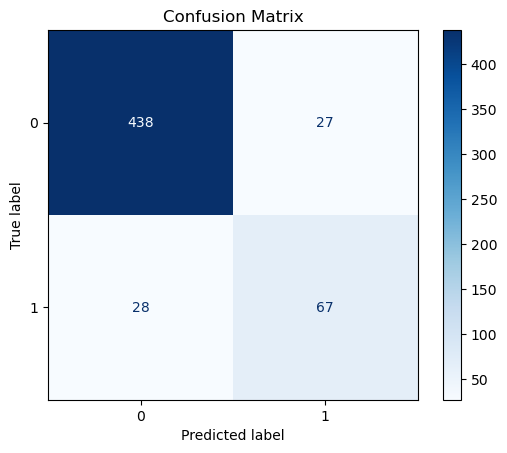

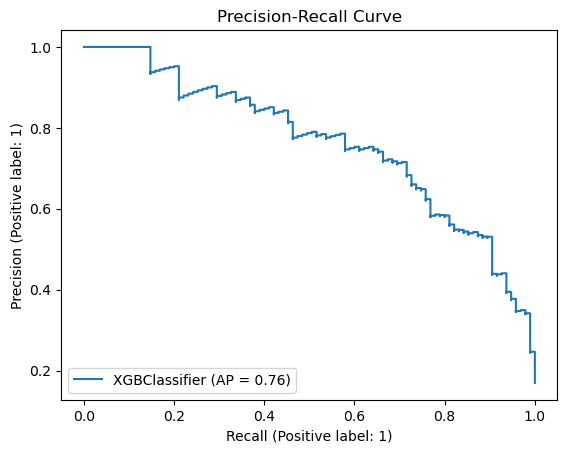

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blupes')
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(best_xgb, X_test_scaled, y_test)
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
def business_evaluation(y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)
    
    # Business metrics
    match_recall = cm[1,1] / cm[1,:].sum()  # Percentage of matches found
    false_alarm_rate = cm[0,1] / cm[0,:].sum()  # Wasted effort rate
    
    # Cost analysis (example values)
    match_value = 100  # Value of correctly identifying a match
    false_alarm_cost = 10  # Cost of pursuing a non-match
    
    profit = cm[1,1]*match_value - cm[0,1]*false_alarm_cost
    
    print(f"\nBusiness Metrics:")
    print(f"Matches Found: {match_recall:.1%}")
    print(f"False Alarm Rate: {false_alarm_rate:.1%}")
    print(f"Estimated Profit: ${profit}")

XGBoostError: [10:37:44] /workspace/src/common/quantile.cc:95: Check failed: h_weights.size() == batch.Size() (2240 vs. 2418) : Invalid size of sample weight.
Stack trace:
  [bt] (0) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x2a6ecc) [0x743ec10a6ecc]
  [bt] (1) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x3efa4a) [0x743ec11efa4a]
  [bt] (2) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5fba94) [0x743ec13fba94]
  [bt] (3) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5e71e0) [0x743ec13e71e0]
  [bt] (4) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5ea949) [0x743ec13ea949]
  [bt] (5) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x57b541) [0x743ec137b541]
  [bt] (6) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x178) [0x743ec0fb93c8]
  [bt] (7) /home/jerono/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(+0xa052) [0x743f2423c052]
  [bt] (8) /home/jerono/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(+0x8925) [0x743f2423a925]



In [15]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score
import joblib

# Selected features based on importance analysis
selected_features = ['feature1', 'feature2', 'feature3', ..., 'feature15']  # Replace with actual top features

# Prepare data
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights
from sklearn.utils.class_weight import compute_sample_weight
weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Create pipeline
final_model = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),  # Oversample minority to 30% of majority
    ('xgb', XGBClassifier(**final_params))
])

# Train
final_model.fit(X_train, y_train, xgb__sample_weight=weights)

# Evaluate
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

# Save model
joblib.dump(final_model, 'optimized_imbalanced_xgb_model.pkl')

# Save feature list for future use
import json
with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f)

KeyError: "None of [Index(['feature1', 'feature2', 'feature3', Ellipsis, 'feature15'], dtype='object')] are in the [columns]"

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
import joblib
import json

# Selected top features based on importance (excluding cluster_attr_match with 0 importance)
selected_features = [
    'personality_alignment',
    'total_attr_compat',
    'like_o',
    'samerace',
    'ambition_gap',
    'age_compatibility',
    'attr_perception_gap',
    'gender',
    'prob_o',
    'age_o',
    'int_corr',
    'age',
    'attr_gap',
    'gender_attr_interaction'
]

# Updated final parameters with feature importance consideration
final_params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': 100,  # Inverse of approximate class ratio
    'max_depth': 5,  # Slightly reduced to prevent overfitting on important features
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,  # Increased slightly since we have fewer features
    'gamma': 1.5,  # Increased to be more conservative on splits
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'n_estimators': 400,  # Increased to allow more iterations with lower learning rate
    'random_state': 42,
    'eval_metric': 'aucpr'
}

# Prepare data with selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Create optimized pipeline
final_model = Pipeline([
    ('smote', SMOTE(
        random_state=42,
        sampling_strategy=0.3,  # Balance minority to 30% of majority
        k_neighbors=3  # More conservative with fewer neighbors
    )),
    ('xgb', XGBClassifier(**final_params))
])

# Calculate sample weights
from sklearn.utils.class_weight import compute_sample_weight
weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train model
final_model.fit(X_train, y_train, xgb__sample_weight=weights)

# Evaluate
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

print("Optimized Model Performance:")
print(classification_report(y_test, y_pred))
print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

# Save model and feature information
joblib.dump(final_model, 'final_optimized_xgb_model.pkl')

with open('selected_features.json', 'w') as f:
    json.dump({
        'features': selected_features,
        'feature_importance': dict(zip(selected_features, final_model.named_steps['xgb'].feature_importances_))
    }, f)

print("Model and feature information saved successfully.")

XGBoostError: [10:38:17] /workspace/src/common/quantile.cc:95: Check failed: h_weights.size() == batch.Size() (2240 vs. 2418) : Invalid size of sample weight.
Stack trace:
  [bt] (0) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x2a6ecc) [0x743ec10a6ecc]
  [bt] (1) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x3efa4a) [0x743ec11efa4a]
  [bt] (2) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5fba94) [0x743ec13fba94]
  [bt] (3) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5e71e0) [0x743ec13e71e0]
  [bt] (4) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5ea949) [0x743ec13ea949]
  [bt] (5) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x57b541) [0x743ec137b541]
  [bt] (6) /home/jerono/anaconda3/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x178) [0x743ec0fb93c8]
  [bt] (7) /home/jerono/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(+0xa052) [0x743f2423c052]
  [bt] (8) /home/jerono/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(+0x8925) [0x743f2423a925]



In [18]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
import joblib
import json
import numpy as np

# Selected top features
selected_features = [
    'personality_alignment',
    'total_attr_compat',
    'like_o',
    'samerace',
    'ambition_gap',
    'age_compatibility',
    'attr_perception_gap',
    'gender',
    'prob_o',
    'age_o',
    'int_corr',
    'age',
    'attr_gap',
    'gender_attr_interaction'
]

# Prepare data with selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Calculate class weights BEFORE SMOTE
from sklearn.utils.class_weight import compute_sample_weight
original_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Create SMOTE instance separately to track samples
smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Create matching weights for resampled data
resampled_weights = np.ones(len(y_res))
resampled_weights[y_res == 1] = original_weights[y_train == 1].mean()  # Minority class
resampled_weights[y_res == 0] = original_weights[y_train == 0].mean()  # Majority class

# Final model parameters
final_params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': 100,
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1.5,
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'n_estimators': 400,
    'random_state': 42,
    'eval_metric': 'aucpr'
}

# Train final model
final_model = XGBClassifier(**final_params)
final_model.fit(X_res, y_res, sample_weight=resampled_weights)

# Evaluate
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

print("Optimized Model Performance:")
print(classification_report(y_test, y_pred))
print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

# Save model and feature information
joblib.dump(final_model, 'final_optimized_xgb_model.pkl')

with open('selected_features.json', 'w') as f:
    json.dump({
        'features': selected_features,
        'feature_importance': dict(zip(selected_features, final_model.feature_importances_))
    }, f)

print("Model and feature information saved successfully.")

Optimized Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.70      0.82       465
           1       0.38      0.89      0.53        95

    accuracy                           0.74       560
   macro avg       0.68      0.80      0.68       560
weighted avg       0.87      0.74      0.77       560

Average Precision: 0.6376


TypeError: Object of type float32 is not JSON serializable

In [19]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
import joblib
import json
import numpy as np

# Selected top features
selected_features = [
    'personality_alignment',
    'total_attr_compat',
    'like_o',
    'samerace',
    'ambition_gap',
    'age_compatibility',
    'attr_perception_gap',
    'gender',
    'prob_o',
    'age_o',
    'int_corr',
    'age',
    'attr_gap',
    'gender_attr_interaction'
]

# Prepare data with selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Calculate class weights BEFORE SMOTE
from sklearn.utils.class_weight import compute_sample_weight
original_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Create SMOTE instance separately to track samples
smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Create matching weights for resampled data
resampled_weights = np.ones(len(y_res))
resampled_weights[y_res == 1] = original_weights[y_train == 1].mean()  # Minority class
resampled_weights[y_res == 0] = original_weights[y_train == 0].mean()  # Majority class

# Final model parameters
final_params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': 100,
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1.5,
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'n_estimators': 400,
    'random_state': 42,
    'eval_metric': 'aucpr'
}

# Train final model
final_model = XGBClassifier(**final_params)
final_model.fit(X_res, y_res, sample_weight=resampled_weights)

# Evaluate
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

print("Optimized Model Performance:")
print(classification_report(y_test, y_pred))
print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

# Save model and feature information
joblib.dump(final_model, 'final_optimized_xgb_model.pkl')

# Convert numpy float32 to native Python float for JSON serialization
feature_importance = {
    feature: float(importance)  # Convert numpy float32 to Python float
    for feature, importance in zip(selected_features, final_model.feature_importances_)
}

with open('selected_features.json', 'w') as f:
    json.dump({
        'features': selected_features,
        'feature_importance': feature_importance
    }, f, indent=4)

print("Model and feature information saved successfully.")

Optimized Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.70      0.82       465
           1       0.38      0.89      0.53        95

    accuracy                           0.74       560
   macro avg       0.68      0.80      0.68       560
weighted avg       0.87      0.74      0.77       560

Average Precision: 0.6376
Model and feature information saved successfully.


In [20]:
print("Number of features:", len(features))  # Should be 14
print("Feature order:", feature_order)  # Must match training
print("Sample features:", features[:3])  # Check first few values

Number of features: 15


NameError: name 'feature_order' is not defined

In [ ]:
df.columns

Index(['gender', 'age', 'age_o', 'samerace', 'int_corr', 'total_attr_compat',
       'personality_alignment', 'attr_perception_gap', 'ambition_gap',
       'gender_attr_interaction', 'age_compatibility', 'cluster_attr_match',
       'attr_gap', 'like_o', 'prob_o', 'dec_o', 'match'],
      dtype='object')